In [1]:
import cloudknot as ck

In [2]:
ck.set_region('us-east-1')

In [3]:
def afq_prek_api(subject):
    import logging
    import s3fs
    import numpy as np
    import os.path as op
    import os

    import AFQ.api as api
    
    logging.basicConfig(level=logging.INFO)
    log = logging.getLogger(__name__)  

    fs = s3fs.S3FileSystem()
    
    os.mkdir(op.join(op.expanduser('~'), "prek"))
    os.mkdir(op.join(op.expanduser('~'), f"prek/sub{subject}"))
    os.mkdir(op.join(op.expanduser('~'), f"prek/sub{subject}/sess"))
    os.mkdir(op.join(op.expanduser('~'), f"prek/sub{subject}/sess/anat"))
    os.mkdir(op.join(op.expanduser('~'), f"prek/sub{subject}/sess/dwi"))
    os.mkdir(op.join(op.expanduser('~'), f"afq"))
    os.mkdir(op.join(op.expanduser('~'), f"afq/sub{subject}"))
    os.mkdir(op.join(op.expanduser('~'), f"afq/sub{subject}/sess"))
    
    #fs.get(f"prek-diffusion/derivatives/afq/sub{subject}", op.join(op.expanduser('~'), "afq/"), recursive=True)

    # use matlab tractography
    fs.get(f"prek-diffusion/mat2py/tract_test_sub-{subject}.trk",
           f"afq/sub{subject}/sess/dwi_aligned_trilin_space-RASMM_model-DTI_desc-det_tractography.trk")
    
    dwi_dir = f'prek-diffusion/derivatives/sub-{subject}/dtiInit_ses-pre'
    derivatives_dir_local = op.join(op.expanduser('~'), f"prek/sub{subject}/sess")

    prek_fdata_src = op.join(dwi_dir, f"sub-{subject}_ses-pre_acq-b1500_dwi_aligned_trilin.nii.gz")
    prek_fbval_src = op.join(dwi_dir, f"sub-{subject}_ses-pre_acq-b1500_dwi_aligned_trilin.bvals")
    prek_fbvec_src = op.join(dwi_dir, f"sub-{subject}_ses-pre_acq-b1500_dwi_aligned_trilin.bvecs")
    
    prek_fdata = op.join(derivatives_dir_local, f"dwi/dwi_aligned_trilin.nii.gz")
    prek_fbval = op.join(derivatives_dir_local, f"dwi/dwi_aligned_trilin.bvals")
    prek_fbvec = op.join(derivatives_dir_local, f"dwi/dwi_aligned_trilin.bvecs")
    
    fs.get(prek_fdata_src, prek_fdata)
    fs.get(prek_fbval_src, prek_fbval)
    fs.get(prek_fbvec_src, prek_fbvec)

    b0_threshold = 50

    tracking_params = {"n_seeds": 2, "directions": 'det', "stop_threshold": 0.3,
                       "min_length": 50, "max_length": 250}
    segmentation_params = {"prob_threshold": 10, "b0_threshold": b0_threshold}
    clean_params = {"clean_rounds": 1}

    myafq = api.AFQ(op.join(op.expanduser('~'), f"prek"),
                    dwi_folder="dwi",
                    dwi_file="dwi*",
                    virtual_frame_buffer=True,
                    b0_threshold=b0_threshold,
                    #wm_fa_thresh=0.2,

                    tracking_params=tracking_params,
                    segmentation_params=segmentation_params,
                    clean_params=clean_params)
    #myafq.get_streamlines()
    myafq.get_template_xform()
    myafq.export_bundles()
    myafq.get_tract_profiles()
    myafq.export_bundle_gif()
    myafq.export_ROI_gifs()
    fs.put(op.join(op.expanduser('~'), "afq"), "prek-diffusion/derivatives_mat", recursive=True)

In [4]:
#afq_prek_api(1110)

In [ ]:
afq_knot = ck.Knot(name='afq_prek-64gb-20622-0',
                  func=afq_prek_api,
                  base_image='libglxvfb:1',
                  image_github_installs="https://github.com/yeatmanlab/pyAFQ.git",
                  pars_policies=('AmazonS3FullAccess',),
                  resource_type="SPOT",
                  bid_percentage=100,
                  memory=64000)

In [ ]:
inputs = [1110,
          1112,
          1113]

In [ ]:
ft = afq_knot.map(inputs)

In [ ]:
afq_knot.view_jobs()

In [10]:
j0 = afq_knot.jobs[0]

In [13]:
j0.status

{'status': 'PENDING',
 'statusReason': None,
 'attempts': [],
 'arrayProperties': {'statusSummary': {'STARTING': 1,
   'FAILED': 0,
   'RUNNING': 18,
   'SUCCEEDED': 0,
   'RUNNABLE': 2,
   'SUBMITTED': 0,
   'PENDING': 0},
  'size': 21}}

In [15]:
afq_knot.clobber()

In [16]:
import s3fs
s3 = s3fs.S3FileSystem(anon=False)

try:
    s3.get(f'prek-diffusion/derivatives/AFQ_allvols_rt_ses-pre_19-Nov-2019.mat', 'source.mat')
except FileNotFoundError:
    print(f'mAFQ streamlines not found')
    
# use AFQ browser to process this

In [28]:
for subject in inputs:
    try:
        s3.get(f'prek-diffusion/derivatives_fa/afq/sub{subject}/sess/dwi_aligned_trilin_profiles.csv', f'sub-{subject}_pyAFQ_profiles.csv')
    except FileNotFoundError:
        print(f'subject {subject} streamlines not found')

In [29]:
import pandas as pd
import numpy as np
profiles_matlab = pd.read_csv('./AFQ-browser/client/data/nodes.csv')

In [30]:
def tract_map(name):
    if name == 'Right Corticospinal':
        return 'CST_R'
    elif name == 'Left Corticospinal':
        return 'CST_L'
    elif name == 'Right Uncinate':
        return 'UNC_R'
    elif name == 'Left Uncinate':
        return 'UNC_L'
    elif name == 'Left IFOF':
        return 'IFO_L'
    elif name == 'Right IFOF':
        return 'IFO_R'
    elif name == 'Right Arcuate':
        return 'ARC_R'
    elif name == 'Left Arcuate':
        return 'ARC_L'
    elif name == 'Right Thalamic Radiation':
        return 'ATR_R'
    elif name == 'Left Thalamic Radiation':
        return 'ATR_L'
    elif name == 'Right Cingulum Cingulate':
        return 'CGC_R'
    elif name == 'Left Cingulum Cingulate':
        return 'CGC_L'
    elif name == 'Right Cingulum Hippocampus':
        return 'HCC_R'
    elif name == 'Left Cingulum Hippocampus':
        return 'HCC_L'
    elif name == 'Callosum Forceps Major':
        return 'FP'
    elif name == 'Callosum Forceps Minor':
        return 'FA'
    elif name == 'Right ILF':
        return 'ILF_R'
    elif name == 'Left ILF':
        return 'ILF_L'
    elif name == 'Right SLF':
        return 'SLF_R'
    elif name == 'Left SLF':
        return 'SLF_L'
    else:
        return name
        
#profiles_matlab['tractID'].unique()
profiles_matlab['subjectID'] = profiles_matlab['subjectID'].apply(lambda x: pd.to_numeric(x[-4:]))
profiles_matlab['tractID'] = profiles_matlab['tractID'].apply(tract_map)

In [31]:
print(profiles_matlab['tractID'].unique())


['ATR_L' 'ATR_R' 'CST_L' 'CST_R' 'CGC_L' 'CGC_R' 'HCC_L' 'HCC_R' 'FP' 'FA'
 'IFO_L' 'IFO_R' 'ILF_L' 'ILF_R' 'SLF_L' 'SLF_R' 'UNC_L' 'UNC_R' 'ARC_L'
 'ARC_R']


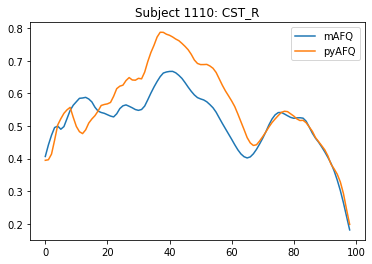

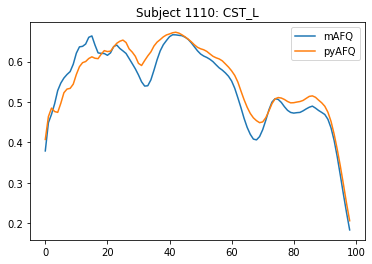

No streamlines found for subject 1110 for bundle UNC_R


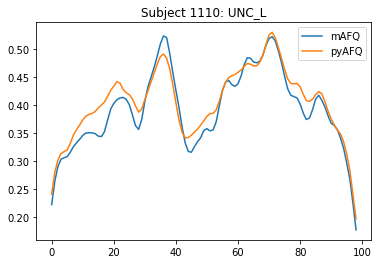

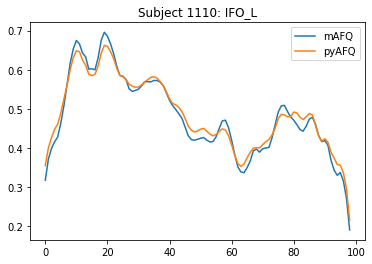

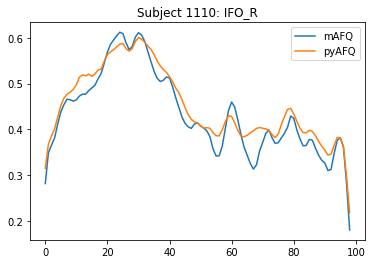

No streamlines found for subject 1110 for bundle ARC_R


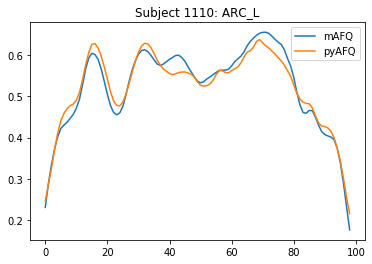

No streamlines found for subject 1110 for bundle ATR_R


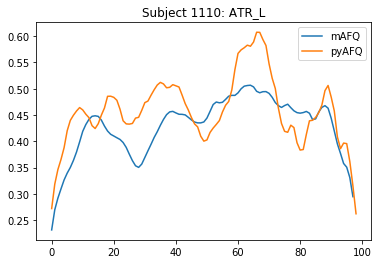

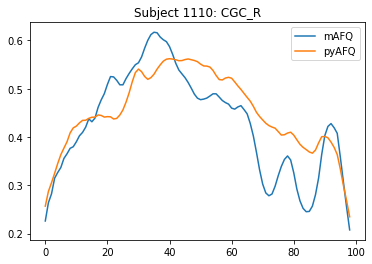

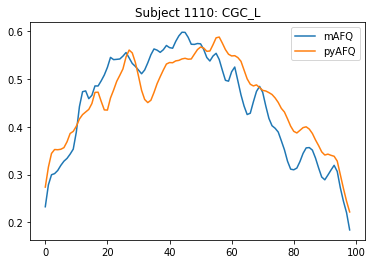

No streamlines found for subject 1110 for bundle HCC_R


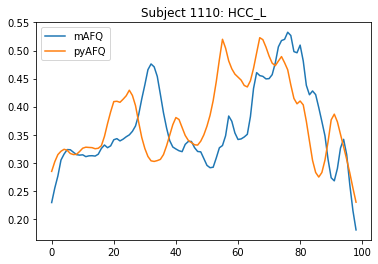

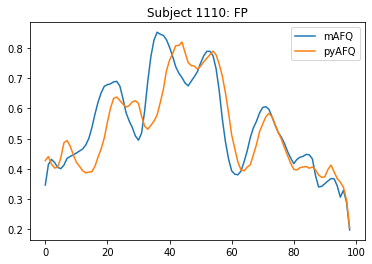

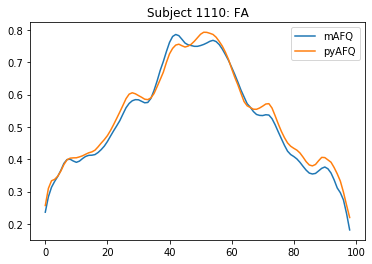

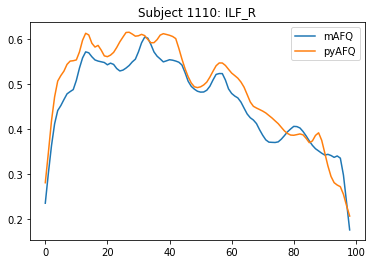

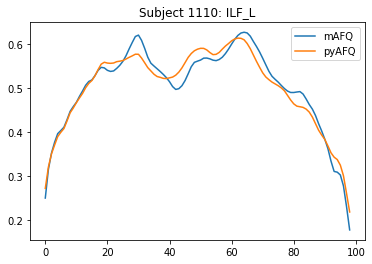

No streamlines found for subject 1110 for bundle SLF_R
No streamlines found for subject 1110 for bundle SLF_L


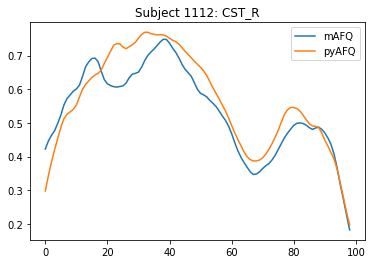

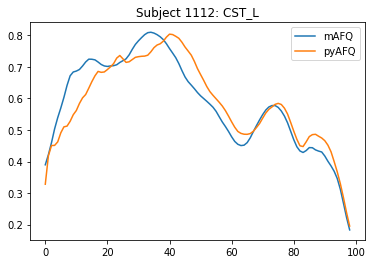

No streamlines found for subject 1112 for bundle UNC_R


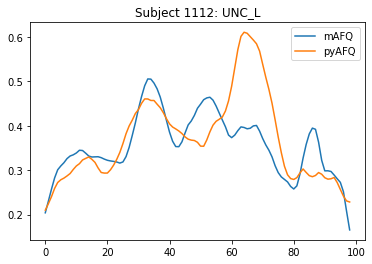

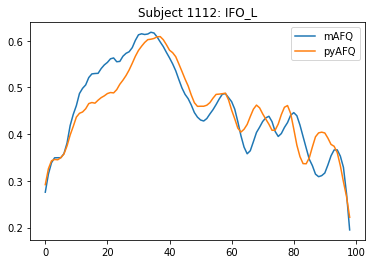

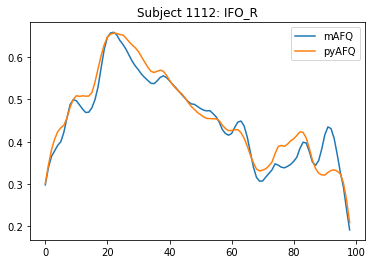

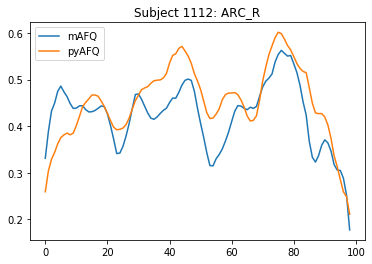

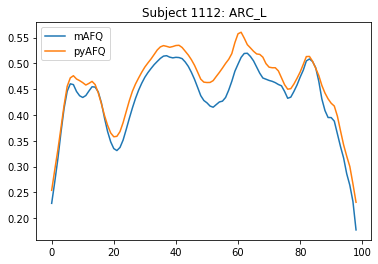

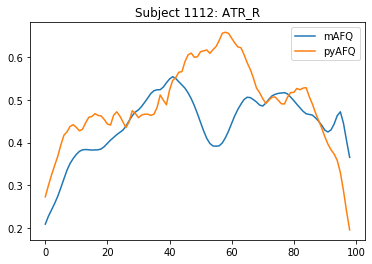

No streamlines found for subject 1112 for bundle ATR_L


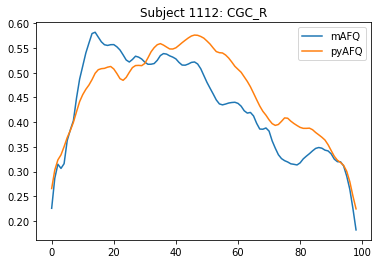

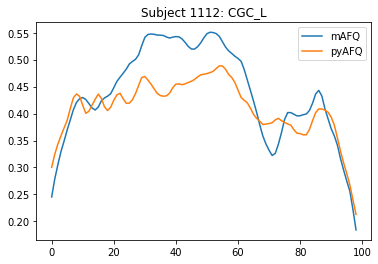

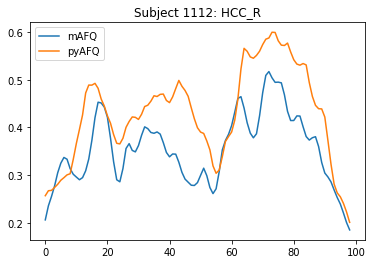

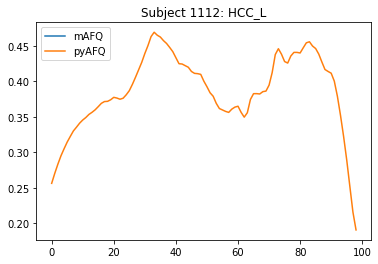

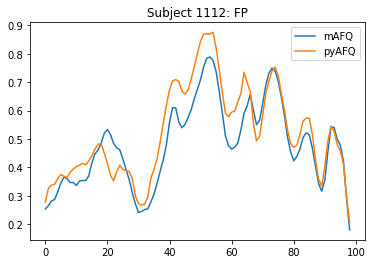

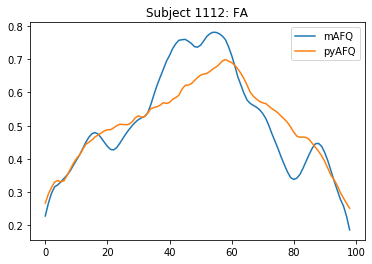

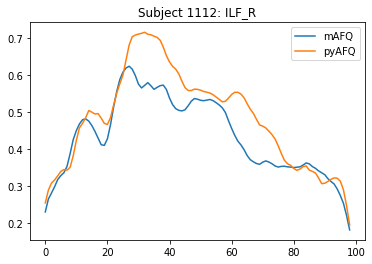

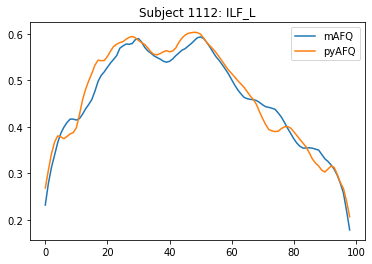

No streamlines found for subject 1112 for bundle SLF_R
No streamlines found for subject 1112 for bundle SLF_L
No streamlines found for subject 1113 for bundle CST_R


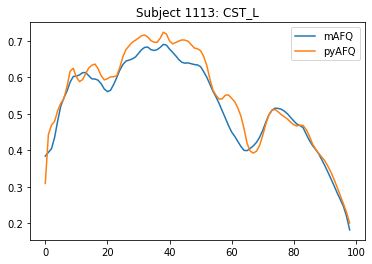

No streamlines found for subject 1113 for bundle UNC_R


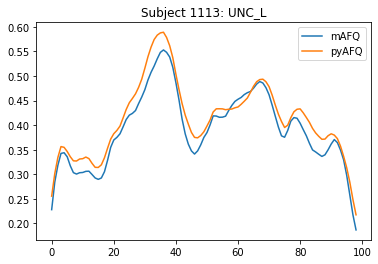

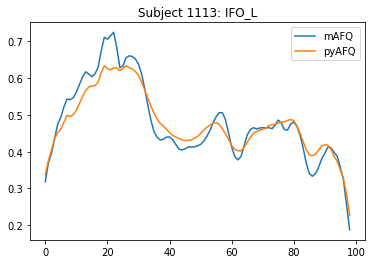

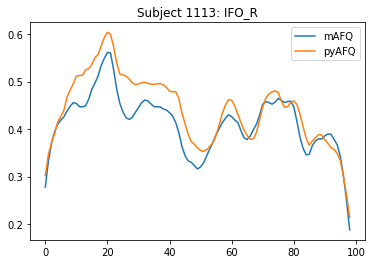

No streamlines found for subject 1113 for bundle ARC_R


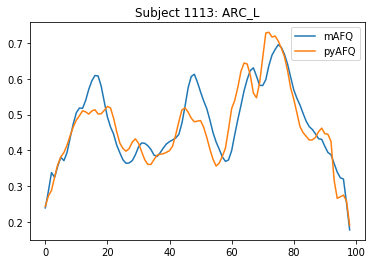

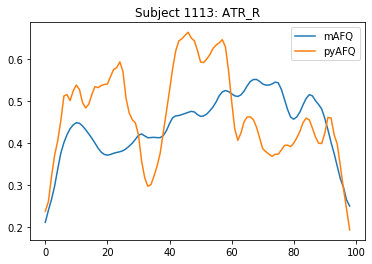

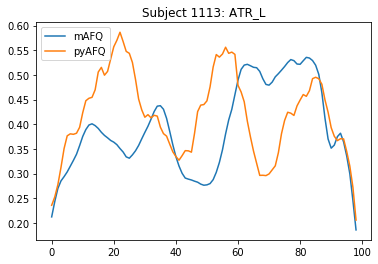

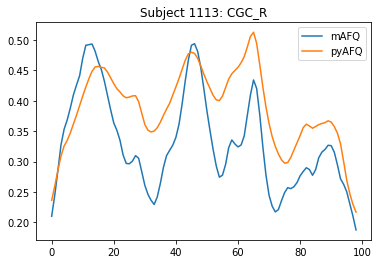

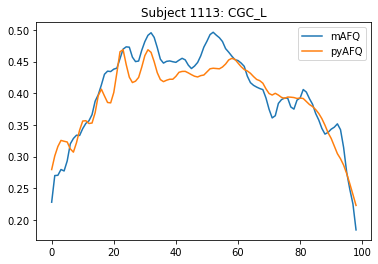

No streamlines found for subject 1113 for bundle HCC_R
No streamlines found for subject 1113 for bundle HCC_L
No streamlines found for subject 1113 for bundle FP


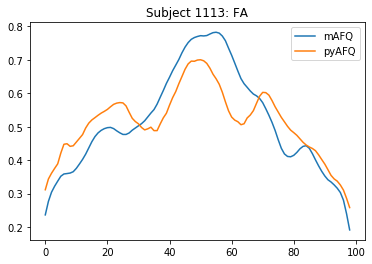

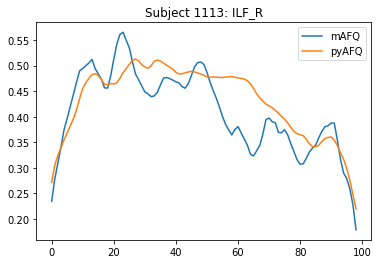

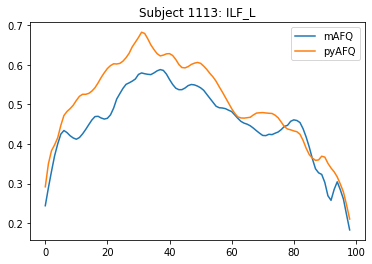

No streamlines found for subject 1113 for bundle SLF_R


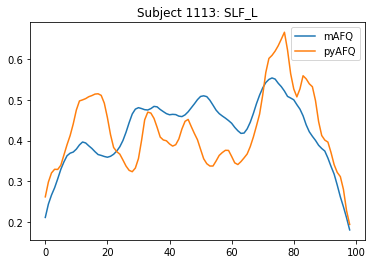

Mean Percent Differences
             1110        1112        1113
CST_R   0.0819731   0.0475238         NaN
CST_L    0.028364   0.0130235   0.0411711
UNC_R         NaN         NaN         NaN
UNC_L   0.0388906   0.0416824   0.0578371
IFO_L   0.0184344  0.00786619  0.00471741
IFO_R   0.0479911   0.0202974   0.0684165
ARC_R         NaN   0.0742304         NaN
ARC_L  0.00476212   0.0632608  -0.0114601
ATR_R         NaN     0.11848   0.0760808
ATR_L         NaN         NaN    0.115387
CGC_R   0.0871686   0.0699097    0.196873
CGC_L   0.0436148  -0.0458927  -0.0144748
HCC_R         NaN    0.212428         NaN
HCC_L   0.0603246         NaN         NaN
FP     -0.0119956   0.0923273         NaN
FA      0.0342179   0.0266795   0.0336664
ILF_R   0.0574302    0.104372    0.062278
ILF_L  0.00254149   0.0132139    0.110606
SLF_R         NaN         NaN         NaN
SLF_L         NaN         NaN   0.0161832


In [32]:
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
bundles = ['CST_R', 'CST_L', 'UNC_R', 'UNC_L',
           'IFO_L', 'IFO_R', 'ARC_R', 'ARC_L',
           'ATR_R', 'ATR_L', 'CGC_R', 'CGC_L',
           'HCC_R', 'HCC_L', 'FP', 'FA',
           'ILF_R', 'ILF_L', 'SLF_R', 'SLF_L']
subjects = [1110, 1112, 1113]

percent_diffs = pd.DataFrame(index=bundles, columns=subjects)
for subject in subjects:
    for bundle in bundles:
        profiles_afq = pd.read_csv(f'sub-{subject}_pyAFQ_profiles.csv')

        ml_test = profiles_matlab[(profiles_matlab['subjectID'] == subject) & (profiles_matlab['tractID'] == bundle)]['fa']
        afq_test = profiles_afq[(profiles_afq['scalar'] == 'dti_fa') & (profiles_afq['bundle'] == bundle)]['profiles']
        ml_test = ml_test.to_numpy()[1:]
        afq_test = afq_test.to_numpy()[1:]
        if (len(afq_test) > 0):
            plt.plot(ml_test)
            plt.plot(afq_test)
            plt.title('Subject ' + str(subject) + ': ' + bundle)
            plt.legend(['mAFQ', 'pyAFQ'])
            plt.show()
            
            percent_diffs.at[bundle, subject] = np.mean((afq_test - ml_test)/ml_test)
        else:
            print('No streamlines found for subject ' + str(subject) + ' for bundle ' + bundle)

print('Mean Percent Differences')
print(percent_diffs) 

In [10]:
print(profiles_matlab['tractID'].unique())
#print(profiles_afq['bundle'].unique())

['Left Thalamic Radiation' 'Right Thalamic Radiation' 'CST_L' 'CST_R'
 'Left Cingulum Cingulate' 'Right Cingulum Cingulate'
 'Left Cingulum Hippocampus' 'Right Cingulum Hippocampus'
 'Callosum Forceps Major' 'Callosum Forceps Minor' 'IFO_L' 'IFO_R'
 'Left ILF' 'Right ILF' 'Left SLF' 'Right SLF' 'UNC_L' 'UNC_R' 'ARC_L'
 'ARC_R']


In [9]:
ml_test = profiles_matlab[(profiles_matlab['subjectID'] == subject) & (profiles_matlab['tractID'] == bundle)]['fa']

In [10]:
ml_test

2300         NaN
2301    0.406386
2302    0.441796
2303    0.471499
2304    0.495186
2305    0.499440
2306    0.489918
2307    0.498059
2308    0.522706
2309    0.547670
2310    0.563576
2311    0.574271
2312    0.584724
2313    0.585748
2314    0.587670
2315    0.582646
2316    0.573634
2317    0.557216
2318    0.545585
2319    0.541261
2320    0.538737
2321    0.534491
2322    0.530308
2323    0.527696
2324    0.537302
2325    0.553245
2326    0.561763
2327    0.564556
2328    0.560319
2329    0.555659
          ...   
2370    0.444613
2371    0.462196
2372    0.481694
2373    0.503084
2374    0.521198
2375    0.534033
2376    0.540955
2377    0.541374
2378    0.536686
2379    0.531270
2380    0.526245
2381    0.523545
2382    0.524835
2383    0.525163
2384    0.523869
2385    0.514359
2386    0.496446
2387    0.477612
2388    0.462474
2389    0.450136
2390    0.435730
2391    0.420324
2392    0.403386
2393    0.385146
2394    0.362250
2395    0.334135
2396    0.301894
2397    0.2642